# SVM

Test Preds files fromat :
Name : fold_0_biobert-v1.1_BCE_with_title_run-0_opt_neg-500 if there is title fold_0_biobert-v1.1_BCE_run-0_opt_neg-500 if not
columns : label,prediction,score,fold,title

one file for the results of one model on one folds

<Figure size 640x480 with 0 Axes>

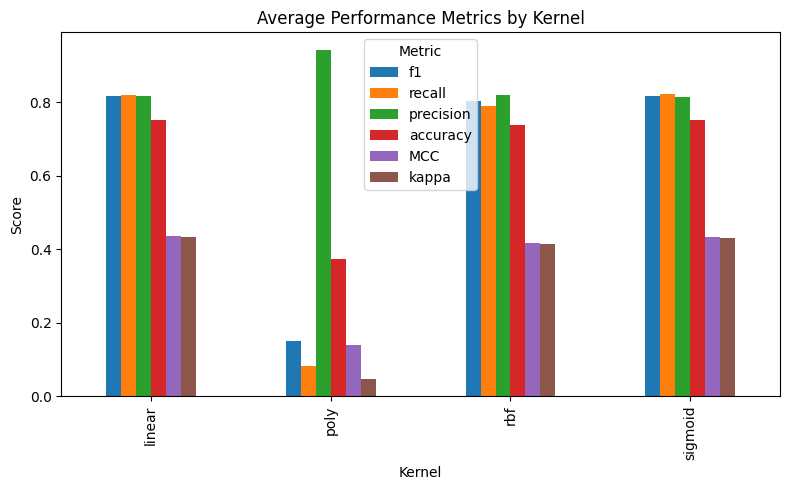

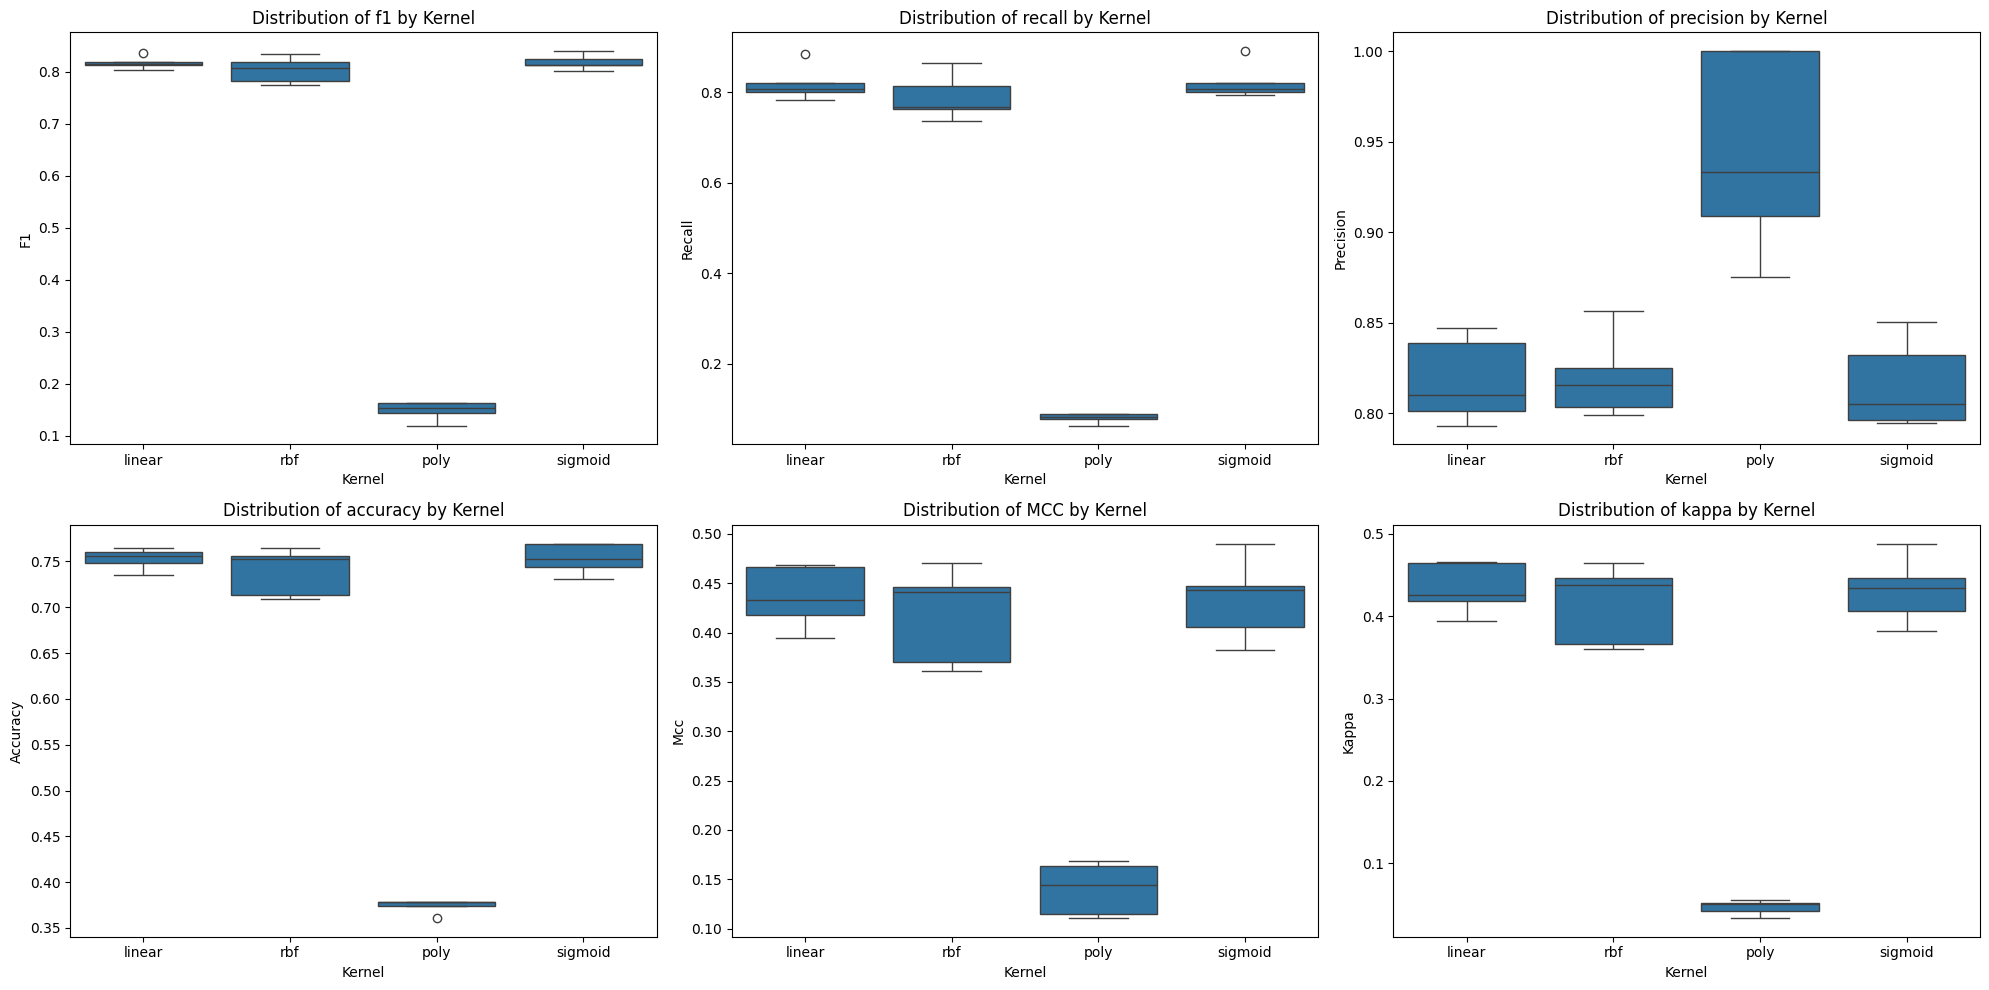

<Figure size 640x480 with 0 Axes>

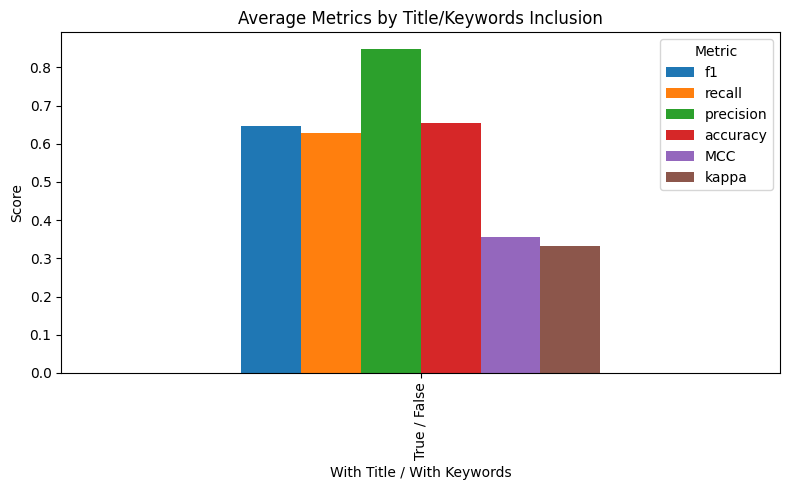

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
svm_df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/metrics/svm_metrics.csv')
svm_df = svm_df.drop(columns=['model_name'])

# Convert problematic columns to numeric (will convert '{}' to NaN)
for col in ['roc_auc', 'AP', 'NDCG']:
    svm_df[col] = pd.to_numeric(svm_df[col], errors='coerce')

# 1. Mean metrics by kernel
mean_by_kernel =svm_df.groupby('kernel')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_kernel.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance Metrics by Kernel')
plt.ylabel('Score')
plt.xlabel('Kernel')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# 2. Boxplot of each metric by kernel
metrics = ['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']
# For each metric, plot BCE vs focal for each model
num_metrics = len(metrics)
n_cols = 3
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax=axes[i]
    sns.boxplot(data=svm_df,x='kernel',y=metric,ax=ax)
    ax.set_title(f'Distribution of {metric} by Kernel')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Kernel')
plt.tight_layout()
plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
svm_df['title_keywords'] = svm_df['with_title'].astype(str) + ' / ' + svm_df['with_keywords'].astype(str)
mean_by_combo = svm_df.groupby('title_keywords')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


# Random Forest

<Figure size 640x480 with 0 Axes>

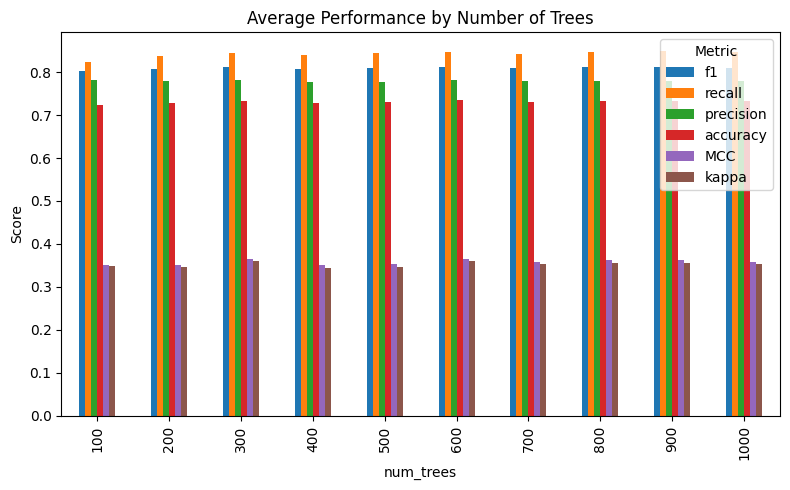

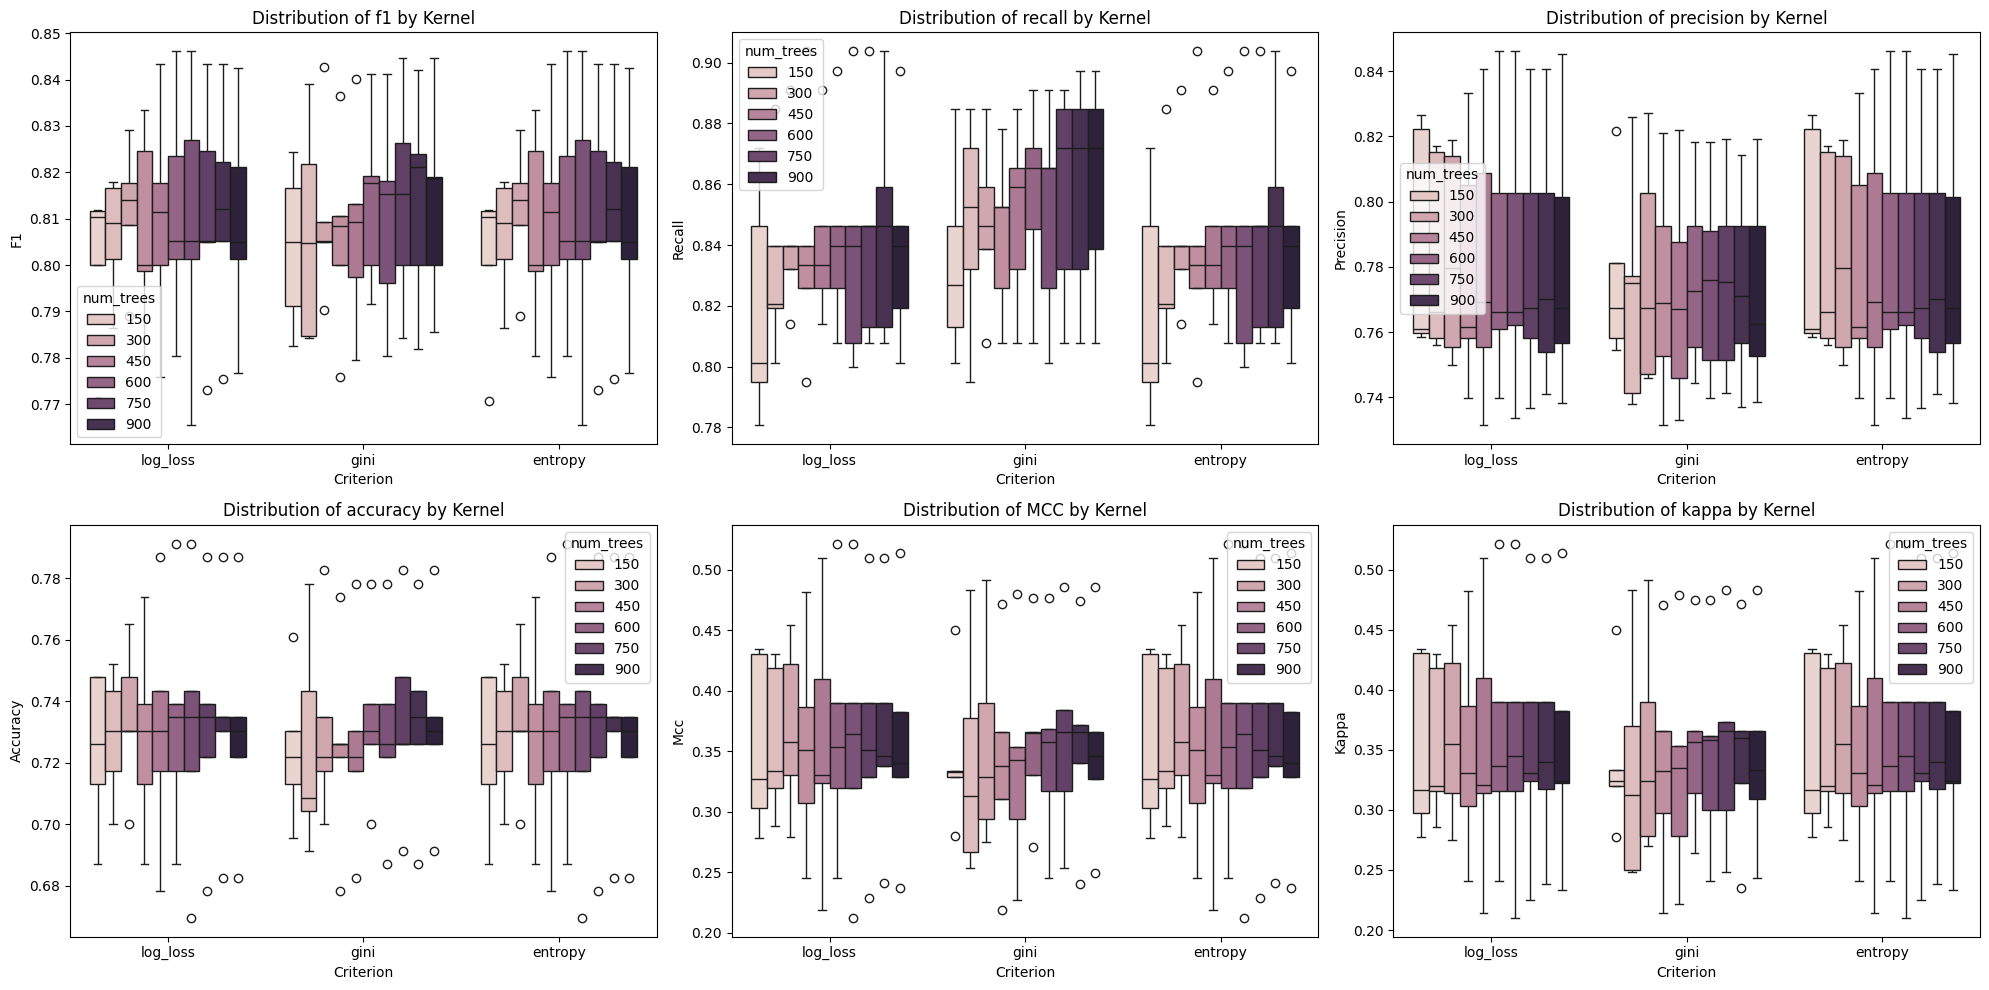

<Figure size 640x480 with 0 Axes>

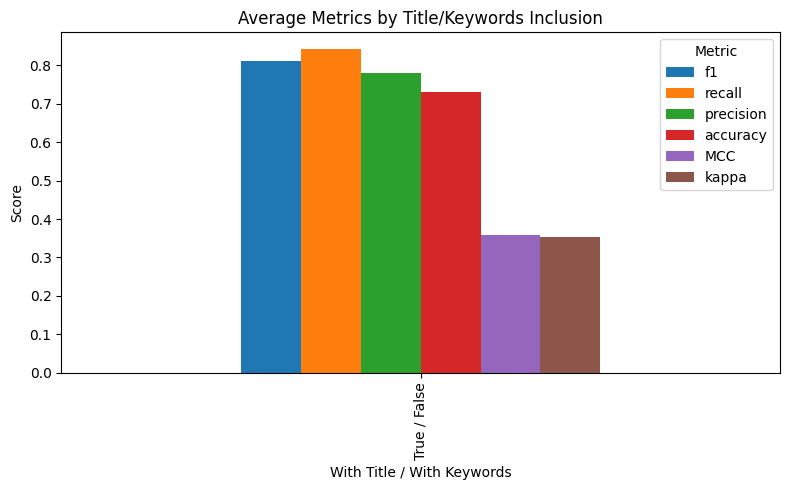

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and prepare the data
rf_df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/metrics/random_forest_metrics.csv')
rf_df = rf_df.drop(columns=['model_name'])

# Convert problematic columns to numeric (will convert '{}' to NaN)
for col in ['roc_auc', 'AP', 'NDCG']:
    rf_df[col] = pd.to_numeric(rf_df[col], errors='coerce')

import matplotlib.pyplot as plt
metrics=['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']
# 1. Average metrics by num_trees
mean_by_trees = rf_df.groupby('num_trees')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()
plt.figure()
mean_by_trees.plot(kind='bar', figsize=(8, 5))
plt.title('Average Performance by Number of Trees')
plt.ylabel('Score')
plt.xlabel('num_trees')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

num_metrics = len(metrics)
n_cols = 3
n_rows = (num_metrics + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax=axes[i]
    sns.boxplot(data=rf_df,x='criterion',y=metric,hue='num_trees',ax=ax)
    ax.set_title(f'Distribution of {metric} by Kernel')
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel('Criterion')
plt.tight_layout()
plt.show()

# 3. Mean metrics by with_title and with_keywords combinations
rf_df['title_keywords'] = rf_df['with_title'].astype(str) + ' / ' + rf_df['with_keywords'].astype(str)
mean_by_combo = rf_df.groupby('title_keywords')[['f1', 'recall', 'precision', 'accuracy', 'MCC', 'kappa']].mean()

plt.figure()
mean_by_combo.plot(kind='bar', figsize=(8, 5))
plt.title('Average Metrics by Title/Keywords Inclusion')
plt.ylabel('Score')
plt.xlabel('With Title / With Keywords')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()


## BERT

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = '/home/leandre/Projects/BioMoQA_Playground/results/metrics/binary_metrics.csv'
bert_df = pd.read_csv(file_path)
bert_df_title=bert_df[bert_df['with_title']==True]
bert_df_abs = bert_df[bert_df['with_title']==False]
bert_df=bert_df_abs

# Load naive baselines
naive_df = pd.read_csv('/home/leandre/Projects/BioMoQA_Playground/results/metrics/naive_metrics.csv')

# Filter out 'focal' and 'BCE' subsets
df_bce = bert_df_title[bert_df_title['loss_type'] == 'BCE']
df_focal = bert_df_title[bert_df_title['loss_type'] == 'focal']

# Define metric columns to aggregate
metric_cols = ['f1', 'recall', 'precision', 'accuracy', 'AP', 'MCC', 'NDCG', 'kappa']

# Aggregate metrics by model_name for BCE
agg_bce = df_bce.groupby('model_name')[metric_cols].mean().reset_index()

# Aggregate metrics by model_name for focal
agg_focal = df_focal.groupby('model_name')[metric_cols].mean().reset_index()


## Combined Data Analysis

## Summary Table: Average Metrics Across Folds

In [4]:
import pandas as pd

# Define metrics to include in summary
summary_metrics = ['f1', 'recall', 'precision', 'accuracy', 'roc_auc', 'AP', 'MCC', 'NDCG', 'kappa']

# Function to create summary table for a model type
def create_summary_table(df, model_type_name, group_cols=['model_name']):
    """Create averaged metrics table for a specific model type"""
    available_metrics = [m for m in summary_metrics if m in df.columns]
    
    if not available_metrics:
        return None
    
    # Group by specified columns and calculate mean across folds
    summary = df.groupby(group_cols)[available_metrics].mean().reset_index()
    
    # Add model type column
    summary.insert(0, 'model_type', model_type_name)
    
    # Round to 4 decimal places for readability
    for metric in available_metrics:
        summary[metric] = summary[metric].round(4)
    
    return summary

# Create summary tables for each model type
print("="*120)
print("SUMMARY TABLE: AVERAGE METRICS ACROSS ALL FOLDS")
print("="*120)

# BERT models with title
if not bert_df_title.empty:
    bert_title_summary = create_summary_table(
        bert_df_title, 
        'BERT (with title)', 
        group_cols=['model_name', 'loss_type']
    )
    print("\n--- BERT Models (with title) ---")
    print(bert_title_summary.to_string(index=False))

# BERT models without title (abstract only)
if not bert_df_abs.empty:
    bert_abs_summary = create_summary_table(
        bert_df_abs, 
        'BERT (abstract only)', 
        group_cols=['model_name', 'loss_type']
    )
    print("\n--- BERT Models (abstract only) ---")
    print(bert_abs_summary.to_string(index=False))

# SVM models
if not svm_df.empty:
    svm_summary = create_summary_table(
        svm_df, 
        'SVM', 
        group_cols=['kernel', 'with_title', 'with_keywords', 'nb_added_negs']
    )
    print("\n--- SVM Models ---")
    # Simplify SVM display
    svm_display = svm_summary.copy()
    svm_display['config'] = svm_display.apply(
        lambda x: f"{x['kernel']}_title-{x['with_title']}_kw-{x['with_keywords']}_neg-{x['nb_added_negs']}", 
        axis=1
    )
    cols_to_drop = ['kernel', 'with_title', 'with_keywords', 'nb_added_negs']
    svm_display = svm_display.drop(columns=cols_to_drop)
    print(svm_display.to_string(index=False))

# Random Forest models
if not rf_df.empty:
    rf_summary = create_summary_table(
        rf_df, 
        'Random Forest', 
        group_cols=['num_trees', 'criterion', 'with_title', 'with_keywords', 'nb_added_negs']
    )
    print("\n--- Random Forest Models ---")
    # Simplify RF display
    rf_display = rf_summary.copy()
    rf_display['config'] = rf_display.apply(
        lambda x: f"trees-{x['num_trees']}_{x['criterion']}_title-{x['with_title']}_kw-{x['with_keywords']}_neg-{x['nb_added_negs']}", 
        axis=1
    )
    cols_to_drop = ['num_trees', 'criterion', 'with_title', 'with_keywords', 'nb_added_negs']
    rf_display = rf_display.drop(columns=cols_to_drop)
    print(rf_display.to_string(index=False))

# Naive baselines
if not naive_df.empty:
    naive_summary = create_summary_table(
        naive_df, 
        'Naive Baseline', 
        group_cols=['approach']
    )
    print("\n--- Naive Baseline Models ---")
    print(naive_summary.to_string(index=False))

print("\n" + "="*120)

# Create a combined summary of best performing configuration for each model family
print("\n" + "="*120)
print("TOP PERFORMERS BY MODEL FAMILY (sorted by F1 score)")
print("="*120)

all_summaries = []

# BERT with title
if 'bert_title_summary' in locals():
    bert_title_summary['model_family'] = 'BERT (with title)'
    bert_title_summary['full_name'] = bert_title_summary['model_name'] + ' [' + bert_title_summary['loss_type'] + ']'
    all_summaries.append(bert_title_summary)

# BERT abstract only
if 'bert_abs_summary' in locals():
    bert_abs_summary['model_family'] = 'BERT (abstract only)'
    bert_abs_summary['full_name'] = bert_abs_summary['model_name'] + ' [' + bert_abs_summary['loss_type'] + ']'
    all_summaries.append(bert_abs_summary)

# SVM
if 'svm_summary' in locals():
    svm_summary['model_family'] = 'SVM'
    svm_summary['full_name'] = svm_display['config']
    all_summaries.append(svm_summary)

# RF
if 'rf_summary' in locals():
    rf_summary['model_family'] = 'Random Forest'
    rf_summary['full_name'] = rf_display['config']
    all_summaries.append(rf_summary)

# Naive
if 'naive_summary' in locals():
    naive_summary['model_family'] = 'Naive Baseline'
    naive_summary['full_name'] = naive_summary['approach']
    all_summaries.append(naive_summary)

if all_summaries:
    combined_summary = pd.concat(all_summaries, ignore_index=True)
    
    # Sort by F1 score (descending)
    if 'f1' in combined_summary.columns:
        combined_summary_sorted = combined_summary.sort_values('f1', ascending=False)
        
        # Select columns for display
        display_cols = ['model_family', 'full_name'] + [m for m in summary_metrics if m in combined_summary.columns]
        top_performers = combined_summary_sorted[display_cols].head(15)
        
        print(top_performers.to_string(index=False))
        print("="*120)


SUMMARY TABLE: AVERAGE METRICS ACROSS ALL FOLDS

--- BERT Models (with title) ---
       model_type        model_name loss_type     f1  recall  precision  accuracy  roc_auc     AP    MCC   NDCG  kappa
BERT (with title)    BiomedBERT-abs       BCE 0.8966  0.9217     0.8731    0.8557   0.9005 0.9399 0.6612 0.9867 0.6580
BERT (with title)    BiomedBERT-abs     focal 0.8729  0.9089     0.8410    0.8209   0.8767 0.9321 0.5797 0.9873 0.5704
BERT (with title) BiomedBERT-abs-ft       BCE 0.8845  0.9037     0.8667    0.8400   0.8965 0.9348 0.6274 0.9861 0.6244
BERT (with title) BiomedBERT-abs-ft     focal 0.8654  0.8896     0.8433    0.8122   0.8635 0.9251 0.5590 0.9862 0.5552
BERT (with title)          Ensemble       BCE 0.9120  0.9358     0.8899    0.8774   0.9258 0.9563 0.7138 0.9920 0.7100
BERT (with title)          Ensemble     focal 0.8748  0.9101     0.8426    0.8235   0.8933 0.9419 0.5828 0.9893 0.5767
BERT (with title)         bert-base       BCE 0.9011  0.9281     0.8763    0.8617   0

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, Dropdown, RadioButtons, Output
from IPython.display import display, clear_output
from IPython import get_ipython

# Clear any previous widgets if re-running this cell
ipy = get_ipython()
if ipy is not None:
    clear_output(wait=False)

metric_cols = ['f1','recall','precision','accuracy','roc_auc','AP','MCC','NDCG','kappa','TN','FP','FN','TP']

for df in [bert_df_title,bert_df_abs, svm_df, rf_df, naive_df]:
    for col in metric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

svm_df['model'] = 'SVM'
rf_df['model'] = 'RF'
naive_df['model'] = 'Naive'

bert_df_title['loss_type'] = bert_df_title['loss_type'].astype(str)
bert_df_abs['loss_type'] = bert_df_abs['loss_type'].astype(str)
svm_df['loss_type'] = 'Baseline'
rf_df['loss_type'] = 'Baseline'
naive_df['loss_type'] = 'Naive'

svm_df['model_name'] = 'SVM'
rf_df['model_name'] = 'RF'
naive_df['model_name'] = naive_df['approach']

baselines=pd.concat([svm_df, rf_df, naive_df], ignore_index=True)

# Create all_runs by combining BERT and baseline models
all_runs = pd.concat([bert_df_title, bert_df_abs, baselines], ignore_index=True)

# Create output widget
output = Output()

def plot_metric(metric, with_title, view):
    with output:
        output.clear_output(wait=True)
        plt.close('all')
        
        # Select data based on with_title parameter
        data = bert_df_title.copy() if with_title=='with_title' else bert_df_abs.copy()
        
        # Get best baseline for each fold
        max_baselines = baselines.iloc[[baselines[baselines['fold']==f][metric].idxmax() for f in baselines['fold'].unique()]].copy()
        max_baselines['model_name'] = 'Best Baseline'
        max_baselines['loss_type'] = 'Baseline'
        
        # Combine data
        data = pd.concat([data, max_baselines], ignore_index=True)
        folds = sorted(data['fold'].unique())
        
        sns.set_theme(style='whitegrid')
        
        # Determine model order
        model_names = list(data['model_name'].unique()) if metric != "roc_auc" and metric != "AP" and metric!='NDCG' else [m for m in all_runs['model_name'].unique() if m not in ['SVM', 'RF', 'always pos']]
        if 'Ensemble' in model_names:
            model_names = [m for m in model_names if m != 'Ensemble']
            model_names.insert(5, 'Ensemble')
        model_order = model_names
        
        if view == 'Subplots':
            n = len(folds)
            ncols = 2
            nrows = (n + 1)//2
            fig, axes = plt.subplots(nrows, ncols, figsize=(14, 5*nrows))
            axes = axes.flatten()

            for i in range(len(folds)):
                fold = folds[i]
                ax = axes[i]
                plot_data = data[data['fold']==fold] if metric != "roc_auc" and metric != "AP" and metric!='NDCG' else data[(data['model_name'] != 'SVM') & (data['model_name'] != 'RF') & (data['model_name'] != 'always pos') & (data['fold'] == fold)]
                
                sns.barplot(
                    data=plot_data,
                    x='model_name', y=metric, hue='loss_type', ax=ax, order=model_order
                )
                ax.set_xlabel("Model Name")
                ax.tick_params(axis='x', rotation=45)
                ax.set_title(f"{metric.upper()} (fold {fold})")
                ax.set_ylabel(metric)
                ax.grid(axis='y', linestyle='--', alpha=0.5)
                ax.legend(fontsize='small')
            
            for j in range(len(folds), len(axes)):
                fig.delaxes(axes[j])
            
            plt.tight_layout()
            plt.show()
        
        else:
            plt.figure(figsize=(12,6))
            plot_data = data if metric != "roc_auc" and metric != "AP" and metric!='NDCG' else data[(data['model_name'] != 'SVM') & (data['model_name'] != 'RF') & (data['model_name'] != 'always pos')]
            
            sns.boxplot(
                data=plot_data,
                x='model_name', y=metric, hue='loss_type', order=model_order
            )
            plt.title(f"{metric.upper()} distribution across folds")
            plt.xticks(rotation=45)
            plt.xlabel("Model Name")
            plt.ylabel(metric)
            plt.grid(axis='y', linestyle='--', alpha=0.5)
            plt.legend(title='Loss type', fontsize='small')
            plt.tight_layout()
            plt.show()

# Create widget
widget = interactive(plot_metric,
    metric=Dropdown(options=metric_cols, description="Metric:", value='f1'),
    with_title=Dropdown(options=['with_title', 'without_title'], description="With Title:", value='with_title'),
    view=RadioButtons(options=['Subplots','Distribution'], description="View:", value='Distribution')
)

display(widget, output)

interactive(children=(Dropdown(description='Metric:', options=('f1', 'recall', 'precision', 'accuracy', 'roc_a…

Output()

In [18]:
import os
import sys
import glob
import logging
from sklearn.metrics import f1_score
from ipywidgets import interactive, Dropdown, Output
from IPython.display import display

logger = logging.getLogger(__name__)

src_dir = os.path.abspath(os.path.join("/home/leandre/Projects/BioMoQA_Playground/src/.."))
if src_dir not in sys.path:
    sys.path.append(src_dir)

from src.config import get_config
from src.utils import plot_roc_curve,plot_precision_recall_curve

config_manager = get_config()
DATA_DIR = '/home/leandre/Projects/BioMoQA_Playground/results/test preds'

best_svm=svm_df.groupby(['kernel','with_title','with_keywords','nb_added_negs'])["f1"].mean().reset_index()
best_svm = best_svm.sort_values(by='f1', ascending=False).head(1)
print('Best SVM parameters:')
print(best_svm[['kernel', 'with_title', 'with_keywords', 'nb_added_negs']])

model_data = {}
for model_type in ["bert","svm"]:
    all_files = glob.glob(os.path.join(DATA_DIR, model_type, '*.csv'))
    for fpath in all_files:
        if model_type == "svm":
            df = pd.read_csv(fpath)
            model_name = os.path.basename(fpath).replace('.csv', '')
            splitted_name = model_name.split('_')
            if splitted_name[1]==best_svm['kernel'].iloc[0] and ('title' in splitted_name if best_svm['with_title'].iloc[0] else not 'title' in splitted_name ) and ("neg-"+str(best_svm['nb_added_negs'].iloc[0]) in splitted_name):
                print(f"Loading SVM model: {model_name} with best parameters")
                model_data["best_svm"]=[df[df["fold"] == i] for i in df["fold"].unique()]
        elif model_type == "bert":
            df = pd.read_csv(fpath)
            fname=os.path.basename(fpath).replace('.csv', '')
            model_name = fname[7:]
            model_data.setdefault(model_name, []).append(df[df["fold"] == int(fname[5])])

output = Output()

def plot_roc_curves(model_name):
    with output:
        output.clear_output(wait=True)
        plt.close('all')
        dfs= model_data[model_name]
        all_folds_df = pd.concat(dfs, ignore_index=True)
        plot_dir = config_manager.get("plots_dir", "plots")
        plot_roc_curve(all_folds_df['label'],all_folds_df['score'],logger=logger, plot_dir=plot_dir,store_plot=False)

widget = interactive(plot_roc_curves, model_name=Dropdown(options=model_data.keys(), description="Models:"))
display(widget, output)

Best SVM parameters:
    kernel  with_title  with_keywords  nb_added_negs
3  sigmoid        True          False            500
Loading SVM model: svm_sigmoid_with_title_run-0_opt_neg-500 with best parameters


interactive(children=(Dropdown(description='Models:', options=('BiomedNLP-BiomedBERT-base-uncased-abstract_foc…

Output()

## In-Domain vs Out-of-Domain Model Comparison

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interactive, Dropdown, Output
from IPython.display import display

output = Output()

def plot_bce_boxplot_with_means(metric, with_title):
    with output:
        output.clear_output(wait=True)
        plt.close('all')
        
        data = bert_df_title if with_title == 'with_title' else bert_df_abs
        bce_data = data[data['loss_type'] == 'BCE'].copy()
        
        if bce_data.empty:
            print("No BCE models found in the data")
            return
        
        plt.figure(figsize=(14, 6))
        model_names = sorted(bce_data['model_name'].unique())
        sns.boxplot(data=bce_data, x='model_name', y=metric, order=model_names, palette='Set2')
        
        means = bce_data.groupby('model_name')[metric].mean()
        for i, model in enumerate(model_names):
            mean_val = means[model]
            y_pos = bce_data[bce_data['model_name'] == model][metric].max()
            plt.text(i, y_pos, f'{mean_val:.3f}', 
                    ha='center', va='bottom', fontweight='bold', fontsize=10,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
        
        plt.xticks(rotation=45, ha='right')
        plt.xlabel('Model Name', fontsize=12)
        plt.ylabel(metric.upper(), fontsize=12)
        plt.title(f'{metric.upper()} Distribution for BCE Models (with mean values)', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print(f"\n{metric.upper()} Statistics for BCE Models:")
        print("=" * 60)
        summary = bce_data.groupby('model_name')[metric].agg(['mean', 'std', 'min', 'max'])
        summary = summary.sort_values('mean', ascending=False)
        print(summary.to_string())

widget = interactive(plot_bce_boxplot_with_means,
    metric=Dropdown(options=['f1','recall','precision','accuracy','roc_auc','AP','MCC','NDCG','kappa'], description="Metric:", value='f1'),
    with_title=Dropdown(options=['with_title', 'without_title'], description="With Title:", value='with_title')
)
display(widget, output)

interactive(children=(Dropdown(description='Metric:', options=('f1', 'recall', 'precision', 'accuracy', 'roc_a…

Output()

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ipywidgets import interactive, Dropdown, Output
from IPython.display import display
import numpy as np

def classify_model_domain(model_name):
    model_lower = model_name.lower()
    if 'biobert' in model_lower or 'biomed' in model_lower:
        return 'In-Domain'
    elif 'bert-base' in model_lower or 'roberta' in model_lower:
        return 'Out-of-Domain'
    elif 'ensemble' in model_lower:
        return 'Ensemble'
    return 'Other'

output = Output()

def compare_domain_models(metric, with_title, loss_type):
    with output:
        output.clear_output(wait=True)
        plt.close('all')
        
        data = bert_df_title if with_title == 'with_title' else bert_df_abs
        if loss_type != 'both':
            data = data[data['loss_type'] == loss_type].copy()
        else:
            data = data.copy()
        
        data['domain'] = data['model_name'].apply(classify_model_domain)
        comparison_data = data[data['domain'].isin(['In-Domain', 'Out-of-Domain'])].copy()
        
        if comparison_data.empty:
            print("No data available for comparison")
            return
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        ax1 = axes[0]
        sns.boxplot(data=comparison_data, x='domain', y=metric, ax=ax1, palette='Set2')
        sns.stripplot(data=comparison_data, x='domain', y=metric, ax=ax1, color='black', alpha=0.3, size=3)
        
        means = comparison_data.groupby('domain')[metric].mean()
        for i, domain in enumerate(['In-Domain', 'Out-of-Domain']):
            if domain in means.index:
                mean_val = means[domain]
                y_pos = comparison_data[comparison_data['domain'] == domain][metric].max()
                ax1.text(i, y_pos, f'Mean: {mean_val:.4f}', 
                        ha='center', va='bottom', fontweight='bold', fontsize=11,
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.7))
        
        ax1.set_xlabel('Model Domain', fontsize=12)
        ax1.set_ylabel(metric.upper(), fontsize=12)
        ax1.set_title(f'{metric.upper()} Comparison: In-Domain vs Out-of-Domain', fontsize=13)
        ax1.grid(axis='y', linestyle='--', alpha=0.3)
        
        ax2 = axes[1]
        model_means = comparison_data.groupby(['model_name', 'domain'])[metric].mean().reset_index()
        model_means = model_means.sort_values(metric, ascending=False)
        colors = ['#66c2a5' if d == 'In-Domain' else '#fc8d62' for d in model_means['domain']]
        ax2.barh(model_means['model_name'], model_means[metric], color=colors)
        ax2.set_xlabel(metric.upper(), fontsize=12)
        ax2.set_ylabel('Model', fontsize=12)
        ax2.set_title(f'Mean {metric.upper()} by Model', fontsize=13)
        ax2.grid(axis='x', linestyle='--', alpha=0.3)
        
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor='#66c2a5', label='In-Domain'),
                          Patch(facecolor='#fc8d62', label='Out-of-Domain')]
        ax2.legend(handles=legend_elements, loc='lower right')
        
        plt.tight_layout()
        plt.show()
        
        in_domain_scores = comparison_data[comparison_data['domain'] == 'In-Domain'][metric].values
        out_domain_scores = comparison_data[comparison_data['domain'] == 'Out-of-Domain'][metric].values
        
        print("\n" + "="*70)
        print(f"STATISTICAL ANALYSIS: {metric.upper()}")
        print("="*70)
        print("\nDescriptive Statistics:")
        print("-" * 70)
        summary = comparison_data.groupby('domain')[metric].agg(['count', 'mean', 'std', 'min', 'max'])
        print(summary.to_string())
        
        print("\n\nMann-Whitney U Test (non-parametric):")
        print("-" * 70)
        statistic, p_value = stats.mannwhitneyu(in_domain_scores, out_domain_scores, alternative='two-sided')
        print(f"U-statistic: {statistic:.4f}")
        print(f"p-value: {p_value:.6f}")
        
        if p_value < 0.001:
            print("Result: *** HIGHLY SIGNIFICANT (p < 0.001)")
        elif p_value < 0.01:
            print("Result: ** SIGNIFICANT (p < 0.01)")
        elif p_value < 0.05:
            print("Result: * SIGNIFICANT (p < 0.05)")
        else:
            print("Result: NOT SIGNIFICANT (p >= 0.05)")
        
        mean_diff = means['In-Domain'] - means['Out-of-Domain']
        pooled_std = np.sqrt((in_domain_scores.var() + out_domain_scores.var()) / 2)
        cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
        
        print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
        if abs(cohens_d) < 0.2:
            print("Effect size: Small")
        elif abs(cohens_d) < 0.5:
            print("Effect size: Small to Medium")
        elif abs(cohens_d) < 0.8:
            print("Effect size: Medium to Large")
        else:
            print("Effect size: Large")
        
        print("\n\nInterpretation:")
        print("-" * 70)
        if mean_diff > 0:
            print(f"In-Domain models perform BETTER by {abs(mean_diff):.4f} points on average.")
        else:
            print(f"Out-of-Domain models perform BETTER by {abs(mean_diff):.4f} points on average.")
        
        print(f"Difference: {mean_diff:.4f} ({(mean_diff/means['Out-of-Domain']*100):.2f}% relative change)")
        print("="*70)

widget = interactive(compare_domain_models,
    metric=Dropdown(options=['f1','recall','precision','accuracy','roc_auc','AP','MCC','NDCG','kappa'], 
                   description="Metric:", value='f1'),
    with_title=Dropdown(options=['with_title', 'without_title'], description="With Title:", value='with_title'),
    loss_type=Dropdown(options=['BCE', 'focal', 'both'], description="Loss Type:", value='BCE')
)
display(widget, output)

interactive(children=(Dropdown(description='Metric:', options=('f1', 'recall', 'precision', 'accuracy', 'roc_a…

Output()

## Recall Precision Curve

dict_keys(['BiomedNLP-BiomedBERT-base-uncased-abstract_focal_with_title_run-0_opt_neg-500', 'bert-base-uncased_BCE_with_title_run-0_opt_neg-500', 'roberta-base_BCE_with_title_run-0_opt_neg-500', 'Ensemble_focal_run-0_opt_neg-500', 'biobert-v1.1_BCE_run-0_opt_neg-500', 'BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_BCE_with_title_run-0_opt_neg-500', 'Ensemble_BCE_with_title_run-0_opt_neg-500', 'bert-base-uncased_BCE_run-0_opt_neg-500', 'biobert-v1.1_focal_run-0_opt_neg-500', 'BiomedNLP-BiomedBERT-base-uncased-abstract_BCE_with_title_run-0_opt_neg-500', 'roberta-base_focal_run-0_opt_neg-500', 'roberta-base_BCE_run-0_opt_neg-500', 'Ensemble_BCE_run-0_opt_neg-500', 'Ensemble_focal_with_title_run-0_opt_neg-500', 'BiomedNLP-BiomedBERT-base-uncased-abstract_BCE_run-0_opt_neg-500', 'BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext_focal_with_title_run-0_opt_neg-500', 'roberta-base_focal_with_title_run-0_opt_neg-500', 'bert-base-uncased_focal_with_title_run-0_opt_neg-500', 'BiomedNLP-B

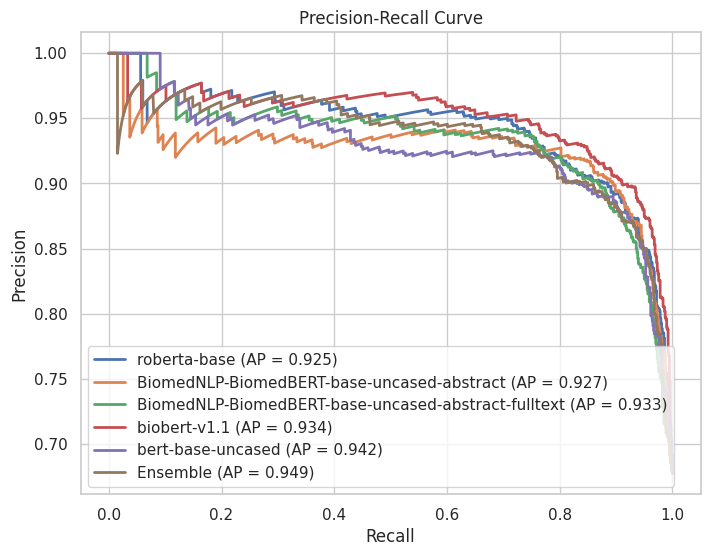

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score


def plot_precision_recall_curve():
    plt.figure(figsize=(8, 6))
    print(model_data.keys())
    avg_precisions = {}
    for model_name in model_data.keys():
        if not 'focal' in model_name and "with_title" in model_name:
            dfs= model_data[model_name]
            all_folds_df = pd.concat(dfs, ignore_index=True)
            y_true = all_folds_df['label']
            y_scores = all_folds_df['score']
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            avg_precisions[model_name]=average_precision_score(y_true, y_scores)
            plt.plot(recall, precision, lw=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve')
            plt.grid(True)
    
    plt.legend([f'{model_name.split("_")[0]} (AP = {avg_precision:.3f})' for (model_name,avg_precision) in sorted(avg_precisions.items(), key=lambda item: item[1])],loc="lower left")
    plt.show()
    return None

plot_precision_recall_curve()

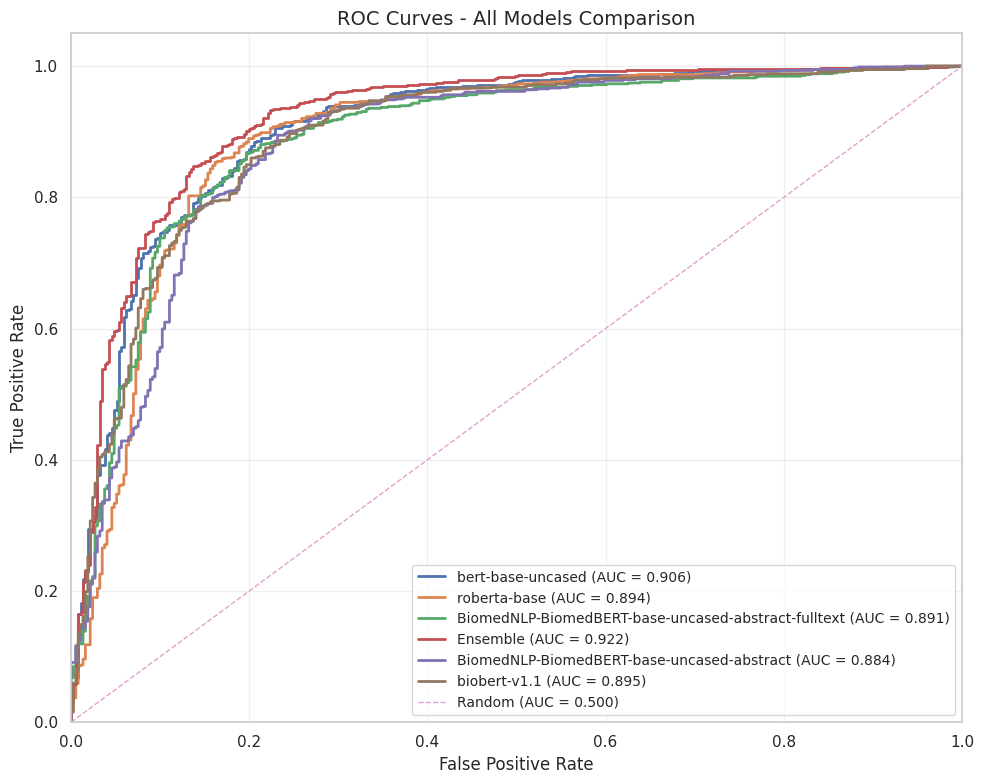

AUC Scores (sorted):
Ensemble: 0.922
bert-base-uncased: 0.906
biobert-v1.1: 0.895
roberta-base: 0.894
BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext: 0.891
BiomedNLP-BiomedBERT-base-uncased-abstract: 0.884


In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves_all_models():
    plt.figure(figsize=(10, 8))
    
    # Store AUC scores for legend
    auc_scores = {}
    
    
    for i, model_name in enumerate(model_data.keys()):
        # Filter for BCE models with title (excluding focal variants for cleaner plot)
        if not 'focal' in model_name and "with_title" in model_name:
            dfs = model_data[model_name]
            all_folds_df = pd.concat(dfs, ignore_index=True)
            y_true = all_folds_df['label']
            y_scores = all_folds_df['score']
            
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            auc_scores[model_name] = roc_auc
            
            # Plot ROC curve
            plt.plot(fpr, tpr, lw=2, 
                    label=f'{model_name.split("_")[0]} (AUC = {roc_auc:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', alpha=0.8, label='Random (AUC = 0.500)')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - All Models Comparison', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print sorted AUC scores
    print("AUC Scores (sorted):")
    for model_name, auc_score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{model_name.split('_')[0]}: {auc_score:.3f}")

plot_roc_curves_all_models()


# Statistical Test

## Friedman + Nemenyi

In [11]:
import numpy as np
from scipy.stats import norm

# Example fold results
metric = 'roc_auc'
metrics_dict={}
for model in bert_df['model_name'].unique():
    fold_results = bert_df[bert_df['model_name'] == model][metric]
    metrics_dict[model]=fold_results.tolist()
k = len(metrics_dict)

for model in metrics_dict:
    metrics= metrics_dict[model]
    # Compute statistics
    mean_recall = np.mean(metrics)
    std_recall = np.std(metrics, ddof=1)  # use ddof=1 for sample std
    se = std_recall / np.sqrt(k)

    # 95% confidence interval
    z = norm.ppf(0.975)  # two-tailed 95% CI
    ci_lower = mean_recall - z * se
    ci_upper = mean_recall + z * se

    print(f"Mean {metric} for model {model} accross folds : {mean_recall:.3f}")
    print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]\n")




Mean roc_auc for model BiomedBERT-abs accross folds : 0.894
95% CI: [0.879, 0.909]

Mean roc_auc for model BiomedBERT-abs-ft accross folds : 0.898
95% CI: [0.885, 0.912]

Mean roc_auc for model roberta-base accross folds : 0.884
95% CI: [0.858, 0.910]

Mean roc_auc for model biobert-v1 accross folds : 0.891
95% CI: [0.872, 0.911]

Mean roc_auc for model bert-base accross folds : 0.891
95% CI: [0.870, 0.911]

Mean roc_auc for model Ensemble accross folds : 0.915
95% CI: [0.904, 0.926]



In [12]:
def get_model_family(model_name):
    model_name = model_name.lower()
    if 'ensemble' in model_name:
        return 'Ensemble'
    if 'roberta' in model_name:
        return 'RoBERTa'
    if 'biomedbert-base-uncased-abstract-fulltext' in model_name:
        return 'BiomedBERT-AF'
    if 'biomedbert' in model_name:
        return 'BiomedBERT-A'
    if 'biobert' in model_name:
        return 'BioBERT'
    if 'bert-base-uncased' in model_name:
        return 'BERT'
    return 'Other'

def abbreviate_name(model_name):
    family = get_model_family(model_name)
    
    if family == 'BiomedBERT-AF':
        label = 'BiomedBERT-AF'
    elif family == 'BiomedBERT-A':
        label = 'BiomedBERT-A'
    else:
        label = family
        
    if 'BCE' in model_name:
        label += ' +BCE'
    elif 'focal' in model_name:
        label += ' +FL'
        
    if 'with_title' in model_name:
        label += ' +T'
    if 'opt_neg-1000' in model_name:
        label += ' (N1k)'
    elif 'opt_neg-500' in model_name:
        label += ' (N500)'
        
    return label




In [13]:
import os
import glob
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from sklearn.metrics import f1_score,roc_auc_score
import matplotlib.pyplot as plt

#print(model_data)
# 2) COMPUTE F1 PER FOLD
perf = {}
for model_name, dfs in model_data.items():
    f1s = [roc_auc_score(d['label'], d['score']) for d in dfs]
    if len(f1s)==5 and "focal" not in model_name:
        perf[abbreviate_name(model_name)] = f1s
if not perf:
    raise ValueError("No performance data found—check your DATA_DIR!")
print(perf)
# Build DataFrame (folds × models)
n_folds = len(next(iter(perf.values())))
fold_idx = list(range(1, n_folds + 1))
perf_df = pd.DataFrame(perf, index=fold_idx)

# 3) FRIEDMAN TEST
stat, p = friedmanchisquare(*[perf_df[col] for col in perf_df.columns])
print(f"Friedman χ² = {stat:.3f}, p = {p:.4f}")
if p >= 0.05:
    print("→ Not significant; stop here.")
else:
    print("→ Significant; running Nemenyi post‑hoc...\n")
    nemenyi_pvals = sp.posthoc_nemenyi_friedman(perf_df)
    #print("Pairwise Nemenyi p‑values:\n", nemenyi_pvals.round(4))

    # 4) CRITICAL‑DIFFERENCE DIAGRAM
    ranks_df = perf_df.rank(axis=1,ascending=False)
    avg_ranks = ranks_df.mean(axis=0)
    plt.figure(figsize=(20, 5))
    plt.title("Critical Difference Diagram for ROC AUC (α = 0.05)")
    # Create significance matrix: True if p < 0.05, else False
    sig_matrix = nemenyi_pvals < 0.05
    print("begin critical difference diagram")
    sp.critical_difference_diagram(avg_ranks.to_dict(), sig_matrix)
    print("Critical Difference Diagram plotted successfully.")
    plt.tight_layout()
    plt.show()
    

{'BERT +BCE +T (N500)': [0.9271483021483021, 0.9144144144144144, 0.9122487872487873, 0.8935913978494624, 0.9164934164934165], 'RoBERTa +BCE +T (N500)': [0.9081774081774081, 0.9083010752688173, 0.8847453222453223, 0.900987525987526, 0.9123354123354123], 'BioBERT +BCE (N500)': [0.9108817204301075, 0.8470200970200971, 0.8997747747747749, 0.8834892584892585, 0.8931046431046431], 'BiomedBERT-AF +BCE +T (N500)': [0.8686763686763687, 0.9251559251559252, 0.9119139784946237, 0.9090869715869716, 0.8675502425502426], 'Ensemble +BCE +T (N500)': [0.933763440860215, 0.9216909216909217, 0.9238565488565489, 0.9233367983367984, 0.9262820512820512], 'BERT +BCE (N500)': [0.9120755370755371, 0.893505376344086, 0.8924116424116425, 0.9250693000693001, 0.8769057519057519], 'BiomedBERT-A +BCE +T (N500)': [0.8966995841995841, 0.8937976437976438, 0.9311827956989247, 0.9183991683991685, 0.8622661122661123], 'RoBERTa +BCE (N500)': [0.9129462365591398, 0.919005544005544, 0.8898128898128898, 0.8567221067221068, 0.8

In [14]:
print(perf)

{'BERT +BCE +T (N500)': [0.9271483021483021, 0.9144144144144144, 0.9122487872487873, 0.8935913978494624, 0.9164934164934165], 'RoBERTa +BCE +T (N500)': [0.9081774081774081, 0.9083010752688173, 0.8847453222453223, 0.900987525987526, 0.9123354123354123], 'BioBERT +BCE (N500)': [0.9108817204301075, 0.8470200970200971, 0.8997747747747749, 0.8834892584892585, 0.8931046431046431], 'BiomedBERT-AF +BCE +T (N500)': [0.8686763686763687, 0.9251559251559252, 0.9119139784946237, 0.9090869715869716, 0.8675502425502426], 'Ensemble +BCE +T (N500)': [0.933763440860215, 0.9216909216909217, 0.9238565488565489, 0.9233367983367984, 0.9262820512820512], 'BERT +BCE (N500)': [0.9120755370755371, 0.893505376344086, 0.8924116424116425, 0.9250693000693001, 0.8769057519057519], 'BiomedBERT-A +BCE +T (N500)': [0.8966995841995841, 0.8937976437976438, 0.9311827956989247, 0.9183991683991685, 0.8622661122661123], 'RoBERTa +BCE (N500)': [0.9129462365591398, 0.919005544005544, 0.8898128898128898, 0.8567221067221068, 0.8

In [15]:
import pandas as pd
import numpy as np
import autorank
import matplotlib.pyplot as plt
import seaborn as sns

original_models = perf_df.columns.tolist()
perf_df.head()

,BERT +BCE +T (N500),RoBERTa +BCE +T (N500),BioBERT +BCE (N500),BiomedBERT-AF +BCE +T (N500),Ensemble +BCE +T (N500),BERT +BCE (N500),BiomedBERT-A +BCE +T (N500),RoBERTa +BCE (N500),Ensemble +BCE (N500),BiomedBERT-A +BCE (N500),BiomedBERT-AF +BCE (N500),BioBERT +BCE +T (N500)
1,0.927148,0.908177,0.910882,0.868676,0.933763,0.912076,0.896700,0.912946,0.930700,0.901117,0.886968,0.890376
2,0.914414,0.908301,0.847020,0.925156,0.921691,0.893505,0.893798,0.919006,0.914414,0.905968,0.891979,0.905579
3,0.912249,0.884745,0.899775,0.911914,0.923857,0.892412,0.931183,0.889813,0.889293,0.908903,0.872574,0.924817
4,0.893591,0.900988,0.883489,0.909087,0.923337,0.925069,0.918399,0.856722,0.920911,0.920478,0.924203,0.898345
5,0.916493,0.912335,0.893105,0.867550,0.926282,0.876906,0.862266,0.893971,0.918538,0.872055,0.914458,0.911383


In [16]:

result = autorank.autorank(perf_df, alpha=0.05, verbose=False)


fig = autorank.plot_stats(result)


plt.title('Critical Difference Diagram of Model F1 Ranks (Nemenyi Test, α=0.05)', fontsize=14)
plt.gca().set_xlabel('Average Rank based on F1 Score', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/cd_plot_main_improved.png', dpi=300)
plt.show()

                              meanrank      mean       std ci_lower ci_upper  \
BioBERT +BCE (N500)                8.8  0.886854  0.024400      NaN      NaN   
BiomedBERT-AF +BCE (N500)          8.0  0.898036  0.020987      NaN      NaN   
BiomedBERT-A +BCE +T (N500)        7.4  0.900469  0.026377      NaN      NaN   
RoBERTa +BCE +T (N500)             7.4  0.902909  0.010946      NaN      NaN   
BiomedBERT-A +BCE (N500)           7.2  0.901704  0.018041      NaN      NaN   
BiomedBERT-AF +BCE +T (N500)       7.2  0.896477  0.026596      NaN      NaN   
BioBERT +BCE +T (N500)             7.0  0.906100  0.013095      NaN      NaN   
RoBERTa +BCE (N500)                7.0  0.894492  0.024445      NaN      NaN   
BERT +BCE (N500)                   6.6  0.899994  0.018758      NaN      NaN   
BERT +BCE +T (N500)                4.9  0.912779  0.012159      NaN      NaN   
Ensemble +BCE (N500)               4.5  0.914771  0.015450      NaN      NaN   
Ensemble +BCE +T (N500)            2.0  

ValueError: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

In [ ]:


perf_df.columns = original_models


mean_scores = perf_df.mean().reset_index()
mean_scores.columns = ['model', 'mean_f1']
mean_scores['family'] = mean_scores['model'].apply(get_model_family)


best_models_per_family = mean_scores.loc[mean_scores.groupby('family')['mean_f1'].idxmax()]
best_model_names = best_models_per_family['model'].tolist()


best_of_family_df = perf_df[best_model_names]


best_of_family_df.columns = [abbreviate_name(m) for m in best_model_names]



result_best_family = autorank.autorank(best_of_family_df, alpha=0.05, verbose=False)
fig_best_family = autorank.plot_stats(result_best_family, 
                                      fig_size=(8, 4))

plt.title('CD Plot of Best Performing Model from Each Family', fontsize=14)
plt.gca().set_xlabel('Average Rank based on F1 Score', fontsize=12)
plt.tight_layout()
plt.savefig('../reports/cd_plot_best_family.png', dpi=300)
plt.show()